In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("airline_passengers.csv", index_col="Month", parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df.tail()

,Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [3]:
df.isna().sum()

Passengers    0
dtype: int64

<AxesSubplot: xlabel='Month'>

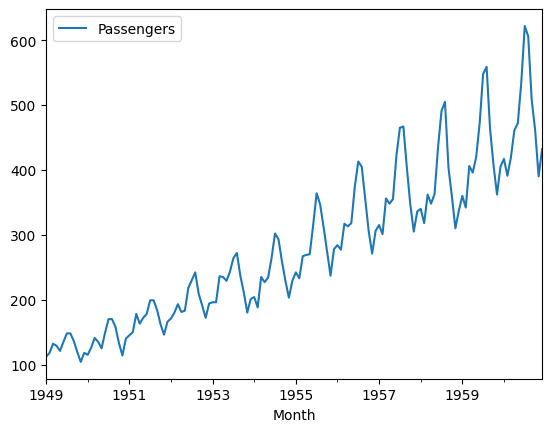

In [4]:
df.plot()

In [6]:
alpha=0.2

In [7]:
df["EWMA"] = df.ewm(alpha=alpha,adjust=False).mean()

<AxesSubplot: xlabel='Month'>

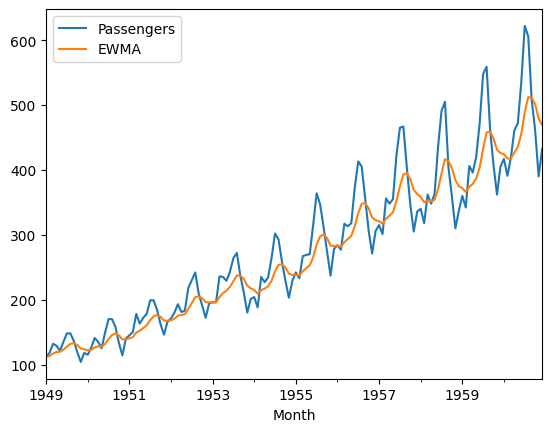

In [8]:
df.plot()

In [10]:
df.head()

,Passengers,EWMA
Month,,
1949-01-01,112,112.0000
1949-02-01,118,113.2000
1949-03-01,132,116.9600
1949-04-01,129,119.3680
1949-05-01,121,119.6944


In [9]:
type(df["Passengers"].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

In [11]:
def manual_ewma(ewma_t_minus_one,x_t,alpha):
    return alpha * x_t + (1-alpha)*ewma_t_minus_one
df["MANUAL_EWMA"] = np.zeros(len(df))

ewma_t_minus_one = df["Passengers"][0]

for i,row in df.iterrows():
    ewma_t_minus_one = manual_ewma(ewma_t_minus_one,row["Passengers"],alpha)
    df.loc[i,"MANUAL_EWMA"] = ewma_t_minus_one

<AxesSubplot: xlabel='Month'>

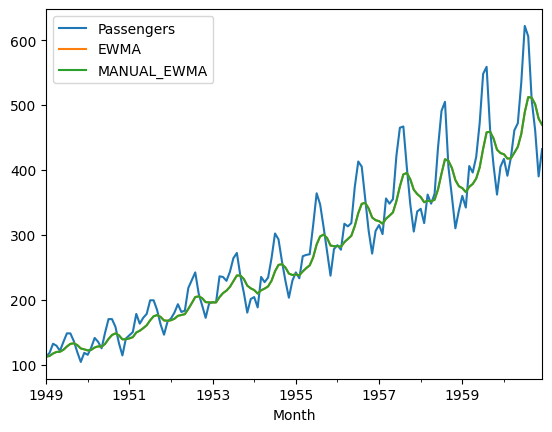

In [12]:
df.plot()

<AxesSubplot: xlabel='Month'>

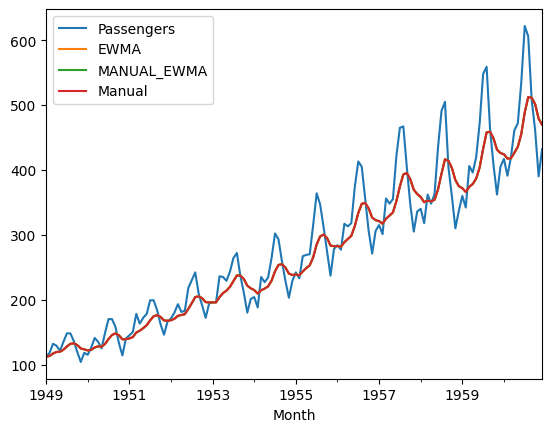

In [14]:
# lazy programmer solution
manual_ewma = []

for x in df["Passengers"].to_numpy():
    if len(manual_ewma)>0:
        x_hat = alpha * x + (1-alpha)*manual_ewma[-1]
    else:
        x_hat = x
    manual_ewma.append(x_hat)

df["Manual"]=manual_ewma
df.plot()

In [16]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [17]:
# initialize simple exponential smoothing model
# we get warning saying no frequency information was provided. The reason is that pandas didn't assign frequency to the index at initiation

ses = SimpleExpSmoothing(df["Passengers"])

c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [18]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [19]:
# MS means month
df.index.freq='MS'

In [21]:
# legacy-heuristics means it will work just like before
ses = SimpleExpSmoothing(df["Passengers"], initialization_method="legacy-heuristic")

In [23]:
res=ses.fit(smoothing_level=alpha,optimized=False)

In [24]:
res

In [25]:
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [26]:
df["SES"] = res.predict(start=df.index[0], end=df.index[-1])


In [27]:
np.allclose(df["SES"], res.fittedvalues)

True

<AxesSubplot: xlabel='Month'>

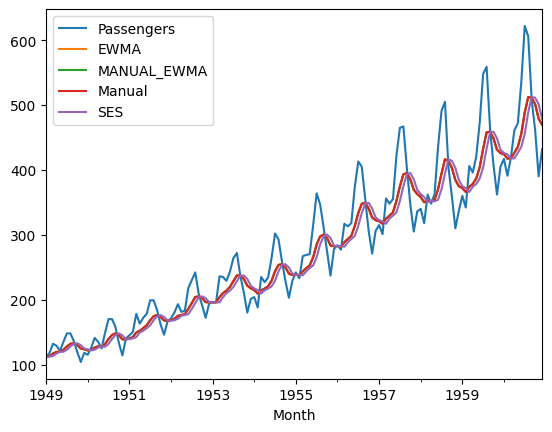

In [28]:
df.plot()

In [29]:
df.head()

,Passengers,EWMA,MANUAL_EWMA,Manual,SES
Month,,,,,
1949-01-01,112,112.0000,112.0000,112.0000,112.000
1949-02-01,118,113.2000,113.2000,113.2000,112.000
1949-03-01,132,116.9600,116.9600,116.9600,113.200
1949-04-01,129,119.3680,119.3680,119.3680,116.960
1949-05-01,121,119.6944,119.6944,119.6944,119.368


In [30]:
df["SES-1"] = df["SES"].shift(-1)

<AxesSubplot: xlabel='Month'>

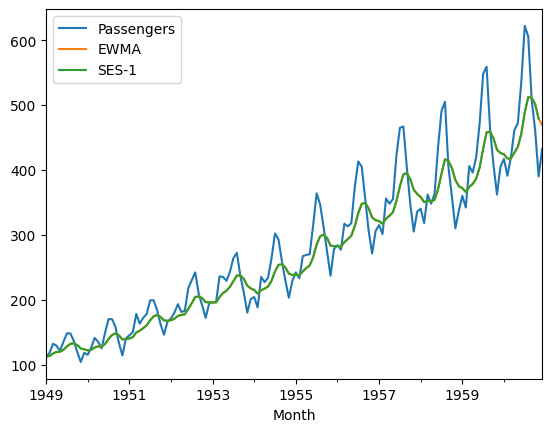

In [31]:
# No don't do
# forecastign is slightly different than EWMA
# SES model should be lagging behind 
df[["Passengers","EWMA", "SES-1"]].plot()

# Treat like a machine learning model

In [43]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]


In [44]:
ses = SimpleExpSmoothing(train["Passengers"], initialization_method="legacy-heuristic")

# it will find the best alpha to minimze error between predicted and actual values
res = ses.fit()

In [45]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [42]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

<AxesSubplot: xlabel='Month'>

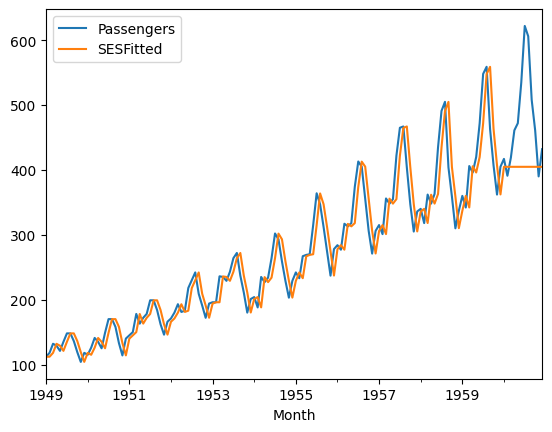

In [46]:
df.loc[train_idx,"SESFitted"] = res.fittedvalues
df.loc[test_idx,"SESFitted"] = res.forecast(N_test)
df[["Passengers","SESFitted"]].plot()

In [47]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

# Holt's Linear Trend Model

In [48]:
from statsmodels.tsa.holtwinters import Holt

In [50]:
model = Holt(df["Passengers"], initialization_method = "legacy-heuristic")

In [51]:
res_h = model.fit()

In [52]:
df["Holt"] = res_h.fittedvalues

<AxesSubplot: xlabel='Month'>

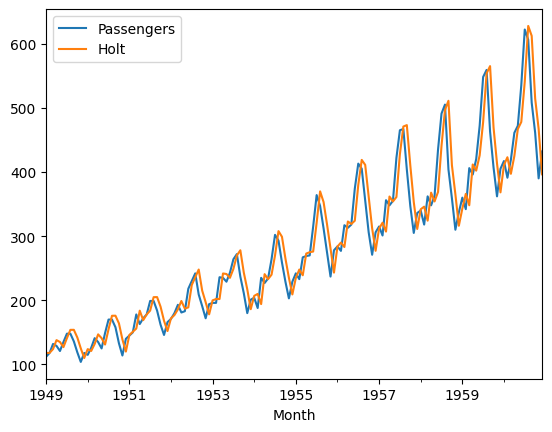

In [53]:
df[["Passengers","Holt"]].plot()

## Forecast test indices

In [54]:
holt = Holt(train["Passengers"], initialization_method="legacy-heuristic")

In [57]:
res_h = holt.fit()

In [59]:
df.loc[train_idx,"Holt"] = res_h.fittedvalues

In [61]:
df.loc[test_idx,"Holt"] = res_h.forecast(N_test)

<AxesSubplot: xlabel='Month'>

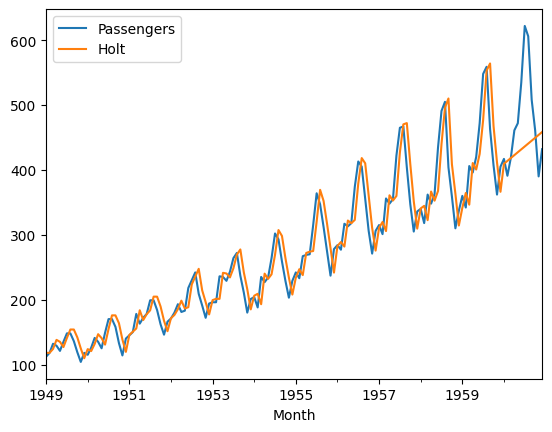

In [62]:
df[["Passengers","Holt"]].plot()